#Importing essential Libraries

In [88]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler
import numpy as np
#Importing some essential Libraries:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler
from matplotlib import image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import imageio
import torchvision.transforms.functional as F
import torch.nn.functional as F1
import torchvision

#Loading Data

In [89]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
load_path_images = '/content/drive/MyDrive/DL/images.npy'
load_path_masks = '/content/drive/MyDrive/DL/masks.npy'
images = np.load(load_path_images)
masks = np.load(load_path_masks)

In [92]:
print("Shapes of images: ", images.shape)
print("Shapes of masks: ", masks.shape)

Shapes of images:  (5088, 240, 240, 3)
Shapes of masks:  (5088, 240, 240)


In [93]:
masks[masks >0.5] = 1.0
masks[masks <= 0.5] = 0.0

Visualizing some images:

Image


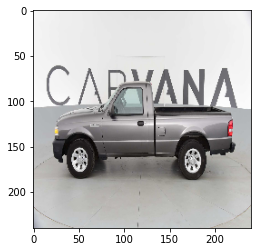

It's Mask


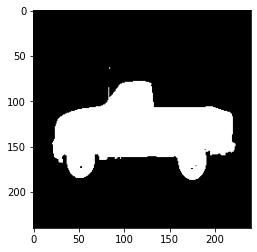

In [94]:
plt.figure(1)
print("Image")
plt.imshow(images[100], cmap= 'gray')
plt.show()
plt.figure(2)
print("It's Mask")
plt.imshow(masks[100], cmap= 'gray')
plt.show()

In [95]:
#validation dataset
val = images[5030:5080,:,:,:]
val_mask = masks[5030:5080,:,:]

In [96]:
#Train Dataset
images = images[0:5000]
masks = masks[0:5000]

In [97]:
import albumentations as A
transform = A.Compose(
    [   A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p=0.5),
        #A.VerticalFlip(p=0.1),
        A.RandomBrightnessContrast(p=0.4)
    ]
)

In [98]:
img_aug = []
mask_aug = []

for j in range(images.shape[0]):
  for i in range(3):  #adding 3 augmentation for each image
    i1 = images[j]
    m = masks[j]
    augmentations = transform(image = i1, masks= [m])
    img_aug.append(augmentations["image"])
    mask_aug.append(augmentations["masks"])

In [99]:
print("Total no of images after augmentation: ", len(img_aug)) 
print("Total no of masks after augmentation: ", len(mask_aug))

Total no of images after augmentation:  15000
Total no of masks after augmentation:  15000


In [100]:
#converting them to numpy array
img_aug = np.array(img_aug)
mask_aug = np.array(mask_aug)
mask_aug = mask_aug.reshape(mask_aug.shape[0], mask_aug.shape[2], mask_aug.shape[3])
print("Shape of augmented image numpy array: ", img_aug.shape)
print("Shape of augmented masks numpy array: ", mask_aug.shape)


Shape of augmented image numpy array:  (15000, 240, 240, 3)
Shape of augmented masks numpy array:  (15000, 240, 240)


Visualizing some data augmentations:

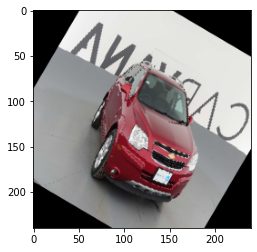

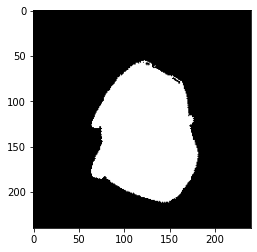

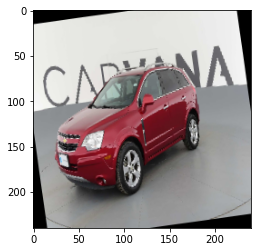

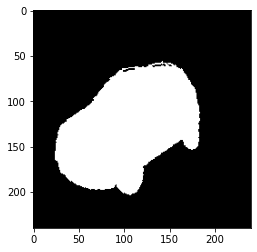

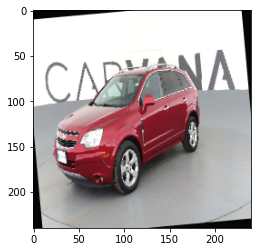

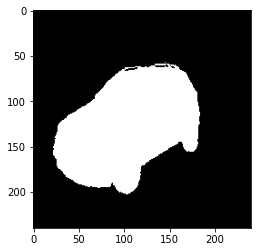

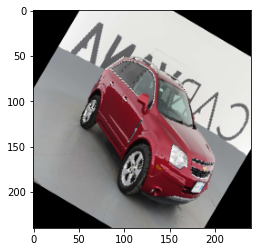

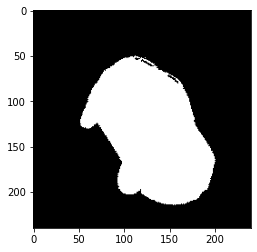

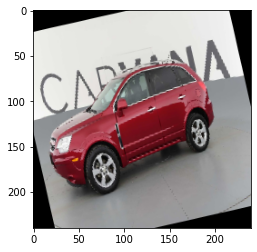

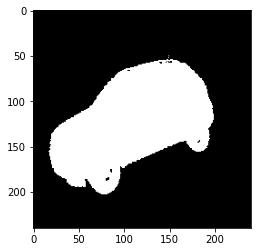

In [101]:
plt.imshow(img_aug[101])
plt.show()
plt.imshow(mask_aug[101], cmap= 'gray')
plt.show()
plt.imshow(img_aug[102])
plt.show()
plt.imshow(mask_aug[102], cmap= 'gray')
plt.show()
plt.imshow(img_aug[103])
plt.show()
plt.imshow(mask_aug[103], cmap= 'gray')
plt.show()
plt.imshow(img_aug[104])
plt.show()
plt.imshow(mask_aug[104], cmap= 'gray')
plt.show()
plt.imshow(img_aug[105])
plt.show()
plt.imshow(mask_aug[105], cmap= 'gray')
plt.show()

Checking if GPU is available

In [102]:
#Converting the images into tensor
if torch.cuda.is_available():
  print("cuda GPU is available")
  DEVICE = 'cuda'
else:
  print("GPU is not available")
  DEVICE = 'cpu'

cuda GPU is available


Transferring the Images to GPU

In [103]:
images = torch.tensor(img_aug, device = DEVICE, dtype = torch.float32)
masks = torch.tensor(mask_aug, device = DEVICE)

In [104]:
val = torch.tensor(val, device = DEVICE, dtype = torch.float32)
val_mask = torch.tensor(val_mask, device = DEVICE)

Reshaping the Image for network to work on

In [105]:
#changing image dimension to that which is accepted by the the model
images = images.permute(0,3,1,2)

In [106]:
val = val.permute(0,3,1,2)

In [107]:
import torchvision.transforms.functional as TF

#Creating Attention_Unet Netowk architecture

##Paper: https://arxiv.org/pdf/1804.03999v3.pdf

In [119]:
class Aunet(nn.Module):

  def __init__(self, in_channels, out_channels):    
    super(Aunet, self).__init__()
    self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv5 = nn.Sequential(
            nn.Conv2d(512, 1024, 3, 1, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, 3, 1, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
        )

    #upsampling layers

    #adding attention part
    self.sig = nn.Sigmoid()
    self.relu = nn.ReLU()
    #self.attn1_conv1 =  nn.Sequential( nn.Conv2d(512, 1024, 1, 2, 0, bias=False), nn.BatchNorm2d(1024))
    self.attn1_conv1 = nn.Conv2d(512, 1024, 1, 2, 0, bias=False)
    #self.attn1_conv2 = nn.Sequential(nn.Conv2d(1024, 1024, 1, 1, 0, bias=False) , nn.BatchNorm2d(1024)) #add after this
    self.attn1_conv2 = nn.Conv2d(1024, 1024, 1, 1, 0, bias=False)
    self.attn1_conv3 =  nn.Conv2d(1024, 1, 1, 1, 0, bias=False)  #take sigmoid after this
    #upsample to match size inside attention layer
    self.attn1_up1 = nn.ConvTranspose2d( 1, 1, kernel_size=2, stride=2, )#multiply and concatenate after this

    self.up1 = nn.ConvTranspose2d( 1024, 512, kernel_size=2, stride=2, )
    self.conv6 = nn.Sequential(
            nn.Conv2d(1024, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
    
    #adding attention part
    #self.attn2_conv1 = nn.Sequential( nn.Conv2d(256, 512, 1, 2, 0, bias=False) , nn.BatchNorm2d(512))
    self.attn2_conv1 = nn.Conv2d(256, 512, 1, 2, 0, bias=False)
    #self.attn2_conv2 = nn.Sequential( nn.Conv2d(512, 512, 1, 1, 0, bias=False) , nn.BatchNorm2d(512)) #add after this
    self.attn2_conv2 = nn.Conv2d(512, 512, 1, 1, 0, bias=False)
    self.attn2_conv3 =  nn.Conv2d(512, 1, 1, 1, 0, bias=False) #take sigmoid after this
    #upsample to match size inside attention layer
    self.attn2_up1 = nn.ConvTranspose2d( 1, 1, kernel_size=2, stride=2, )#multiply and concatenate after this
    
    self.up2 = nn.ConvTranspose2d( 512, 256, kernel_size=2, stride=2, )
    self.conv7 = nn.Sequential(
            nn.Conv2d(512, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
    
    #adding attention part
    #self.attn3_conv1 = nn.Sequential( nn.Conv2d(128, 256, 1, 2, 0, bias=False), nn.BatchNorm2d(256))
    self.attn3_conv1 = nn.Conv2d(128, 256, 1, 2, 0, bias=False)
    #self.attn3_conv2 = nn.Sequential( nn.Conv2d(256, 256, 1, 1, 0, bias=False) , nn.BatchNorm2d(256)) #add after this
    self.attn3_conv2 = nn.Conv2d(256, 256, 1, 1, 0, bias=False)
    self.attn3_conv3 =  nn.Conv2d(256, 1, 1, 1, 0, bias=False) #take sigmoid after this
    #upsample to match size inside attention layer
    self.attn3_up1 = nn.ConvTranspose2d( 1, 1, kernel_size=2, stride=2, )#multiply and concatenate after this

    self.up3 = nn.ConvTranspose2d( 256, 128, kernel_size=2, stride=2, )
    self.conv8 = nn.Sequential(
            nn.Conv2d(256, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
    
    #adding attention part
    #self.attn4_conv1 =  nn.Sequential(nn.Conv2d(64, 128, 1, 2, 0, bias=False), nn.BatchNorm2d(128))
    self.attn4_conv1 = nn.Conv2d(64, 128, 1, 2, 0, bias=False)
    #self.attn4_conv2 = nn.Sequential(nn.Conv2d(128, 128, 1, 1, 0, bias=False), nn.BatchNorm2d(128)) #add after this
    self.attn4_conv2 = nn.Conv2d(128, 128, 1, 1, 0, bias=False)
    self.attn4_conv3 =  nn.Conv2d(128, 1, 1, 1, 0, bias=False) #take sigmoid after this
    #upsample to match size inside attention layer
    self.attn4_up1 = nn.ConvTranspose2d( 1, 1, kernel_size=2, stride=2, )#multiply and concatenate after this

    self.up4 = nn.ConvTranspose2d( 128, 64, kernel_size=2, stride=2, )
    self.conv9 = nn.Sequential(
            nn.Conv2d(128, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
    self.conv_final = nn.Conv2d(64, out_channels, 3, 1, 1)               #output channel is the no of classes
    
  def forward(self, input):

    #Downsampling Part
    out = self.conv1(input)
    out_1 = out
    out = self.pool1(out)       #()

    out = self.conv2(out)
    out_2 = out
    out = self.pool2(out)

    out = self.conv3(out)
    out_3 = out
    out = self.pool3(out)
    
    out = self.conv4(out)
    out_4 = out
    out = self.pool4(out)
    
    out = self.conv5(out)
    gate = out
    
    #Upsampling part
    #adding attention layer:    
    out = self.up1(out) 
    atn1 = self.attn1_conv1(out_4)
    atn2 = self.attn1_conv2(gate)
    atn = atn1 + atn2
    atn = self.relu(atn)
    atn = self.attn1_conv3(atn)
    atn = self.sig(atn)
    atn = self.attn1_up1(atn)
    atn = out_4*atn

    #print(atn.shape)

    """if out_4.shape != out.shape:
      out = TF.resize(out, size= [out_4.shape[2], out_4.shape[3]])"""
    
    out = torch.cat((atn, out), dim = 1)
    out = self.conv6(out)
    gate = out


    out = self.up2(out)  

    #adding attention layer:    
    atn1 = self.attn2_conv1(out_3)
    atn2 = self.attn2_conv2(gate)
    atn = atn1 + atn2
    atn = self.relu(atn)
    atn = self.attn2_conv3(atn)
    atn = self.sig(atn)
    atn = self.attn2_up1(atn)
    atn = out_3*atn

    #print(atn.shape)
    """if out_3.shape != out.shape:
      out = TF.resize(out, size= [out_3.shape[2], out_3.shape[3]]) """
    out = torch.cat((atn, out), dim = 1)
    out = self.conv7(out)
    gate = out

    out = self.up3(out)

    #adding attention layer:    
    atn1 = self.attn3_conv1(out_2)
    atn2 = self.attn3_conv2(gate)
    atn = atn1 + atn2
    atn = self.relu(atn)
    atn = self.attn3_conv3(atn)
    atn = self.sig(atn)
    atn = self.attn3_up1(atn)
    atn = out_2*atn

    #print(atn.shape)
    """if out_2.shape != out.shape:
      out = TF.resize(out, size= [out_2.shape[2], out_2.shape[3]])"""    
    out = torch.cat((atn, out), dim = 1)
    out = self.conv8(out)
    gate = out

    out = self.up4(out) 

    #adding attention layer:    
    atn1 = self.attn4_conv1(out_1)
    atn2 = self.attn4_conv2(gate)
    atn = atn1 + atn2
    atn = self.relu(atn)
    atn = self.attn4_conv3(atn)
    atn = self.sig(atn)
    atn = self.attn4_up1(atn)
    atn = out_1*atn

    #print(atn.shape)


    """if out_1.shape != out.shape:
      out = TF.resize(out, size= [out_1.shape[2], out_1.shape[3]])"""    
    out = torch.cat((atn, out), dim = 1)
    out = self.conv9(out)

    out = self.conv_final(out)

    return out

In [120]:
model = Aunet(3,2).to(device = DEVICE)

In [121]:
model(images[0].reshape(1, images[0].shape[0], images[0].shape[1], images[0].shape[2])).shape

torch.Size([1, 2, 240, 240])

In [122]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)        #update the weights of the model 
loss_type = torch.nn.CrossEntropyLoss()
step_lr = lr_scheduler.StepLR(optimizer, step_size= 100, gamma = 0.5)  

#Training the model using pytorch dataloader and other pytorch tools

In [123]:
from torch.utils.data import Dataset, DataLoader     #Importing Dataloader

In [124]:
class CustomImageDataset(Dataset):    #Making the class that takes the index and gives the images and it's corrosponding masks
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return images.shape[0]

    def __getitem__(self, idx):
        x_batch = self.images[idx]
        y_batch = self.masks[idx]
        return x_batch, y_batch

In [125]:
data = CustomImageDataset(images, masks)  #data is the object for the class that takes index and gives data and it's mask

In [126]:
batchsize = 25
dataloader = DataLoader(dataset= data, batch_size= batchsize, shuffle= True)

In [127]:
pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [128]:
from torchmetrics import JaccardIndex
jaccard = JaccardIndex(num_classes=2)

##Training Network

In [129]:
#Model Training
loss_graph = []
num_epochs = 10   #Here each epoch means that at each epoch the model will train once over the entire datset using sgd on small batches

path_folder = '/content/drive/MyDrive/DL/saved_weights/unet'

for j in range(num_epochs):

  with torch.no_grad():
    model.eval()
    pred = model(val)
    pred = pred.argmax(axis= 1)
    print("Jaccard index before epoch ", j+1, " is: ", jaccard(pred[0].cpu(), val_mask[0].long().cpu()).cpu().item()*100)

    #saving the weights of the model:
    PATH = os.path.join(path_folder, 'model_' + str(j+1)+ '.pth')
    torch.save(model.state_dict(), PATH)


  model.train()
  for i, (x_batch, y_batch) in enumerate(dataloader):

    optimizer.zero_grad()
    y_pred = model(x_batch)
    y_pred = y_pred.permute(0,2,3,1)
    y_pred = y_pred.reshape(-1,2)
    y_batch = y_batch.reshape(-1)
  
    loss = loss_type(y_pred, y_batch)
    loss.backward()
    optimizer.step()
    loss_graph.append(loss.cpu().item())

  print("Epoch: ", j+1, ", loss is: ", loss.cpu().item())

Jaccard index before epoch  1  is:  12.87132054567337
Epoch:  1 , loss is:  0.022357821464538574
Jaccard index before epoch  2  is:  97.04389572143555
Epoch:  2 , loss is:  0.017099551856517792
Jaccard index before epoch  3  is:  98.18726778030396
Epoch:  3 , loss is:  0.010844564065337181
Jaccard index before epoch  4  is:  98.63101840019226
Epoch:  4 , loss is:  0.012060313485562801
Jaccard index before epoch  5  is:  99.07152652740479
Epoch:  5 , loss is:  0.011493072845041752
Jaccard index before epoch  6  is:  98.39969873428345
Epoch:  6 , loss is:  0.008547498844563961
Jaccard index before epoch  7  is:  98.94867539405823
Epoch:  7 , loss is:  0.023285752162337303
Jaccard index before epoch  8  is:  94.38950419425964
Epoch:  8 , loss is:  0.008619062602519989
Jaccard index before epoch  9  is:  98.80825281143188
Epoch:  9 , loss is:  0.009227132424712181
Jaccard index before epoch  10  is:  99.17721152305603
Epoch:  10 , loss is:  0.00972924567759037


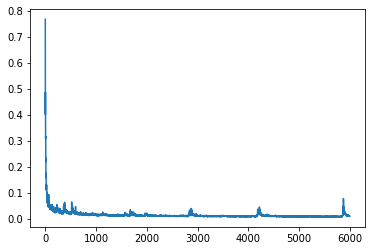

In [130]:
#Loss Graph
plt.plot(loss_graph)  
plt.show()

#Final result from the Trained Model: 

Prediction on seen data (Training data)

Predicted segmentation mask


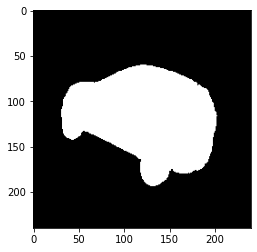

Actual mask


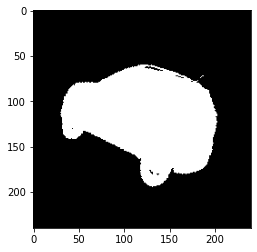

In [132]:
model.eval()
y = model(images[111].reshape(1,images.shape[1], images.shape[2], images.shape[3]))
y = y.argmax(axis= 1)
y = y.reshape(240,240)
plt.figure(3)
print("Predicted segmentation mask")
plt.imshow(np.array(y.detach().cpu().numpy()), cmap= 'gray')
plt.show()

plt.figure(4)
print("Actual mask")
plt.imshow(np.array(masks[111].clone().cpu()), cmap= 'gray')
plt.show()

Prediction on unseen data (Validation data)

Predicted segmentation mask


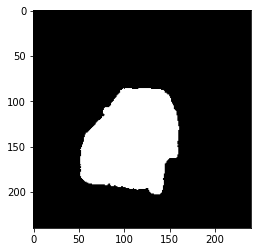

Actual mask


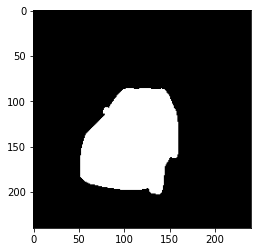

In [133]:
model.eval()
y = model(val[11].reshape(1,val.shape[1], val.shape[2], val.shape[3]))
y = y.argmax(axis= 1)
y = y.reshape(240,240)
plt.figure(3)
print("Predicted segmentation mask")
plt.imshow(np.array(y.detach().cpu().numpy()), cmap= 'gray')
plt.show()

plt.figure(4)
print("Actual mask")
plt.imshow(np.array(val_mask[11].clone().cpu()), cmap= 'gray')
plt.show()